<a href="https://colab.research.google.com/github/kiaurash/MiscFiles/blob/master/ANN_Alg_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries and Read Data

In [4]:
!pip install utils
!pip install mxnet
!pip install xgboost
!pip install statsmodels

     |████████████████████████████████| 68.7MB 73kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [5]:
#From https://github.com/borisbanushev/stockpredictionai#fouriertransform
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
import pandas as pd
import datetime as dt
from datetime import datetime
import pandas_datareader.data as pdr
from pylab import mpl, plt
%matplotlib inline
import json
import requests
import numpy as np
from sklearn import preprocessing

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

In [3]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [ ]:
from tensorflow import keras

In [4]:
# Import TimeSeries packages
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Data Prep

In [9]:
## Define Parameters
symbol = 'SPY'
start = datetime(2001, 1, 1)
end = datetime(2020,7, 16)
#split_date = datetime.date(2008,4,12)

In [11]:
stock_data = pdr.get_data_yahoo(symbol, start, end)
data= pd.DataFrame()
stock=pd.DataFrame()
data[symbol] = stock_data['Close']
data['Open']= stock_data['Open']
data['Low'] = stock_data['Low']
data['High'] =stock_data['High']
data.tail()

,SPY,Open,Low,High
Date,,,,
2020-07-10,317.589996,314.309998,312.760010,317.880005
2020-07-13,314.839996,320.130005,314.130005,322.709991
2020-07-14,318.920013,313.299988,312.000000,319.760010
2020-07-15,321.850006,322.410004,319.269989,323.040009
2020-07-16,320.790009,319.790009,319.089996,321.279999


In [12]:
data.to_csv('/data/close_spy.csv')

FileNotFoundError: ignored

In [10]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

##Create Features

In [7]:
#data['close_ratio'] = data[symbol].pct_change()
# Define Retrun as difference between OPEN and CLOSE
#data['daily_log']= np.log(data[symbol]/data['Open']) #Ratio of Close to Open
#data['diff'] = data[symbol] - data[symbol].shift()
#data['daily_change'] = data[symbol]/ data['Open']
data['return'] =(data[symbol] - data['Open']) #Returns based on difference between Day's Close to Open
data['Updirection'] = np.where(data['return'] > 0, 1, 0) #Overnight direction of the stock
data['Dndirection'] = np.where(data['return'] < 0, 1, 0) #Overnight direction of the stock
data['direction'] = np.where(data['return'] > 0, 1, -1) #Overnight direction of the stock
data.dropna(inplace=True)
data.tail()

,SPY,Open,Low,High,return,Updirection,Dndirection,direction
Date,,,,,,,,
2020-07-10,317.589996,314.309998,312.760010,317.880005,3.279999,1,0,1
2020-07-13,314.839996,320.130005,314.130005,322.709991,-5.290009,0,1,-1
2020-07-14,318.920013,313.299988,312.000000,319.760010,5.620026,1,0,1
2020-07-15,321.850006,322.410004,319.269989,323.040009,-0.559998,0,1,-1
2020-07-16,320.790009,319.790009,319.089996,321.279999,1.000000,1,0,1


In [ ]:
# Ichimoku
T = 9
K = 26
S = 52
data.loc[data.index[1:], 'Tenkan'] = (data.loc[data.index[0:-1],'High'].rolling(T).max().values + data.loc[data.index[0:-1],'Low'].rolling(T).min().values)/2
data.loc[data.index[1:], 'Kinjun'] = (data.loc[data.index[0:-1],'High'].rolling(K).max().values + data.loc[data.index[0:-1],'Low'].rolling(K).min().values)/2
data.loc[data.index[1:], 'SpanB'] = (data.loc[data.index[0:-1],'High'].rolling(S).max().values + data.loc[data.index[0:-1],'Low'].rolling(S).min().values)/2
data['SpanA'] = (data['Tenkan'] + data['Kinjun'])/2

In [ ]:
data.iloc[53:55]

,SPY,Open,Low,High,return,Updirection,Dndirection,direction,Tenkan,Kinjun,SpanB,SpanA
Date,,,,,,,,,,,,
2001-03-20,114.199997,117.900002,114.110001,118.459999,-3.700005,0,1,-1,121.024998,124.489998,126.754997,122.757498
2001-03-21,112.260002,114.180000,111.900002,115.260002,-1.919998,0,1,-1,120.674999,124.139999,126.404999,122.407499


In [8]:
SMA1=3
SMA2 = 8
SMA3= 16
#df.loc[df.index[1:], 'test'] = df.loc[df.index[0:-1],symbol].rolling(SMA1).mean().values
data.loc[data.index[1:], 'SMA1'] = data.loc[data.index[0:-1],symbol].rolling(SMA1).mean().values
data.loc[data.index[1:], 'SMA2'] = data.loc[data.index[0:-1],symbol].rolling(SMA2).mean().values
data.loc[data.index[1:], 'SMA3'] = data.loc[data.index[0:-1],symbol].rolling(SMA3).mean().values
data['OSMA1']= data['Open'].rolling(SMA1).mean()
data['OSMA2']= data['Open'].rolling(SMA2).mean()
data['OSMA3'] = data['Open'].rolling(SMA3).mean()
data['SMA1_ratio'] = data['OSMA1']/data['SMA1']
data['SMA2_ratio'] = data['OSMA2']/data['SMA2']
data['SMA3_ratio'] = data['OSMA3']/data['SMA3']
data['Op_OSMA1'] = data['Open']/data['OSMA1']
data['Op_OSMA2'] = data['Open']/data['OSMA2']
data['Op_OSMA3'] = data['Open']/data['OSMA3']
data['Open_Ratio'] = data['Open']/data['Open'].shift(1) #Ratio of open to last bar's Open
data['OC_Ratio'] = data['Open']/data[symbol].shift(1) # Ratio of Open to last bar's Close

In [ ]:
# Calculate Ratios to Ichimuku
data['PT_ratio'] = data['Open']/data['Tenkan']
data['PK_ratio'] = data['Open']/data['Kinjun']
data['PA_ratio'] = data['Open']/data['SpanA']
data['PB_ratio'] = data['Open']/data['SpanB']

In [9]:
# Create lags for 2nd, 3rd, and 15th day
lags = [1,2,7,8,15]
def create_lags(data):
  global cols
  cols=[]
  for lag in lags:
    col='lag_{}'.format(lag)
    data[col] = data['return'].shift(lag) #Creates the lagged version of the market prices for the current lag value
    cols.append(col)
create_lags(data)
data = data.dropna()
data.tail()

,SPY,Open,Low,High,return,Updirection,Dndirection,direction,SMA1,SMA2,SMA3,OSMA1,OSMA2,OSMA3,SMA1_ratio,SMA2_ratio,SMA3_ratio,Op_OSMA1,Op_OSMA2,Op_OSMA3,Open_Ratio,OC_Ratio,lag_1,lag_2,lag_7,lag_8,lag_15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-10,317.589996,314.309998,312.760010,317.880005,3.279999,1,0,1,314.779999,312.119995,310.199997,315.253326,313.163746,310.740623,1.001504,1.003344,1.001743,0.997008,1.003660,1.011487,0.992015,0.999777,-2.459991,1.570007,4.369995,3.049988,1.769989
2020-07-13,314.839996,320.130005,314.130005,322.709991,-5.290009,0,1,-1,316.049998,313.761246,310.570621,317.093333,315.181248,311.373123,1.003301,1.004526,1.002584,1.009577,1.015701,1.028123,1.018517,1.007998,3.279999,-2.459991,0.949982,4.369995,-5.529999
2020-07-14,318.920013,313.299988,312.000000,319.760010,5.620026,1,0,1,315.603333,314.571247,310.761871,315.913330,315.647495,311.318747,1.000982,1.003421,1.001792,0.991728,0.992563,1.006364,0.978665,0.995109,-5.290009,3.279999,-2.009979,0.949982,2.630005
2020-07-15,321.850006,322.410004,319.269989,323.040009,-0.559998,0,1,-1,317.116669,315.621250,311.404371,318.613332,316.668747,312.219997,1.004720,1.003319,1.002619,1.011916,1.018130,1.032637,1.029078,1.010943,5.620026,-5.290009,0.679993,-2.009979,-1.440002
2020-07-16,320.790009,319.790009,319.089996,321.279999,1.000000,1,0,1,318.536672,316.823750,312.106247,318.500000,317.096249,312.613749,0.999885,1.000860,1.001626,1.004050,1.008495,1.022956,0.991874,0.993600,-0.559998,5.620026,-1.600006,0.679993,-5.750000


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


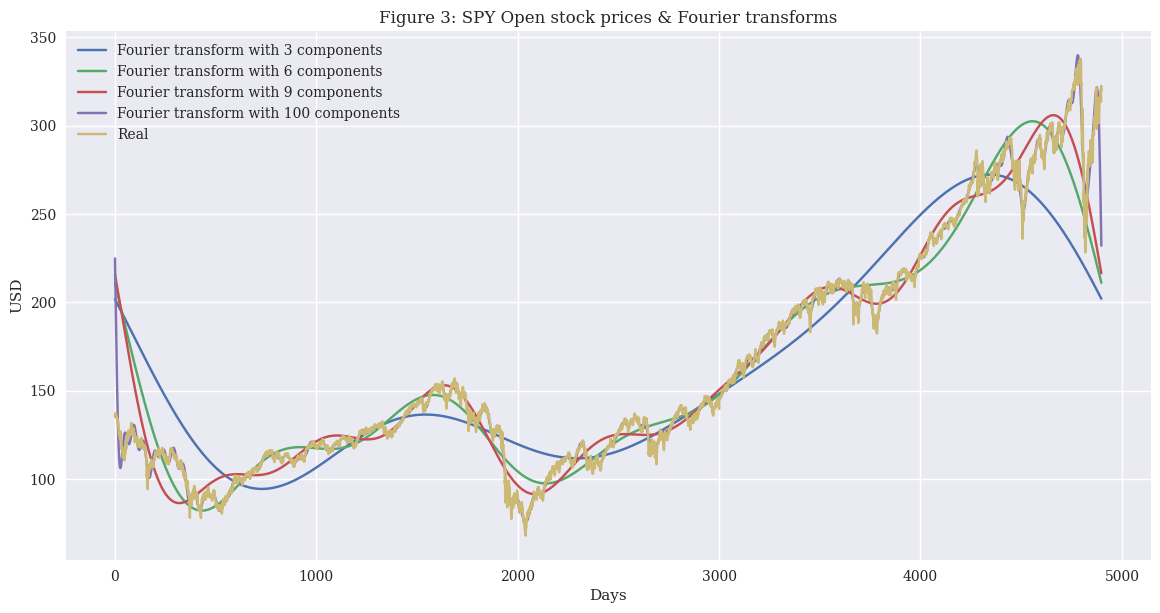

In [10]:
# Fourier Transform
open_fft = np.fft.fft(np.asarray(data['Open'].tolist()))
fft_df = pd.DataFrame({'fft':open_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data['Open'].tolist(),  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: SPY Open stock prices & Fourier transforms')
plt.legend()
plt.show()

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data[symbol]
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.SPY   No. Observations:                 4898
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10306.979
Method:                       css-mle   S.D. of innovations              1.985
Date:                Tue, 28 Jul 2020   AIC                          20627.959
Time:                        01:43:36   BIC                          20673.435
Sample:                             1   HQIC                         20643.914
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0378      0.026      1.464      0.143      -0.013       0.088
ar.L1.D.SPY    -0.1374      0.014     -9.617      0.000      -0.165      -0.109
ar.L2.D.SPY     0.0564      0.014      3.918    

In [ ]:
from google.colab import files
#validation.to_csv('StockValid.csv', header=True)
#files.download('StockValid.csv')


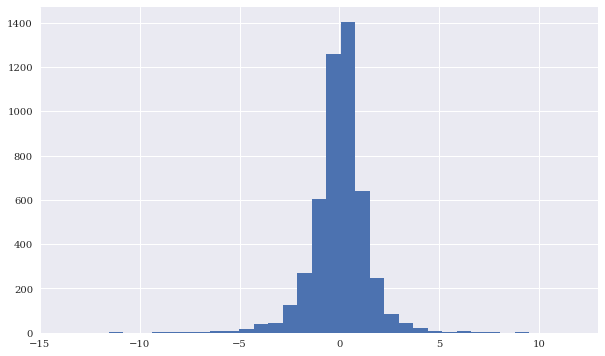

In [ ]:
data['return'].hist(bins=35, figsize=(10,6))

In [ ]:
#!pip install xgboost
#!pip install --upgrade xgboost

In [ ]:
data.columns

Index(['SPY', 'Open', 'Low', 'High', 'return', 'Updirection', 'Dndirection',
       'direction', 'Tenkan', 'Kinjun', 'SpanB', 'SpanA', 'SMA1', 'SMA2',
       'SMA3', 'OSMA1', 'OSMA2', 'OSMA3', 'SMA1_ratio', 'SMA2_ratio',
       'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2', 'Op_OSMA3', 'Open_Ratio',
       'OC_Ratio', 'PT_ratio', 'PK_ratio', 'PA_ratio', 'PB_ratio', 'lag_1',
       'lag_2', 'lag_7', 'lag_8', 'lag_15'],
      dtype='object')

## Feature Ranking

In [ ]:
target='direction'
features = ['Open', 'SMA1', 'Tenkan', 'Kinjun', 'SpanA', 'SpanB',
       'SMA1', 'SMA2', 'SMA3', 'OSMA1', 'OSMA2', 'OSMA3', 'SMA1_ratio',
       'SMA2_ratio', 'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2', 'Op_OSMA3',
       'Open_Ratio', 'OC_Ratio', 'PT_ratio', 'PK_ratio', 'PA_ratio',
       'PB_ratio', 'lag_1', 'lag_2', 'lag_7', 'lag_8', 'lag_15']
train = data['2001-01-05':'2014-12-31']
yTrain = train[target]
xTrain = train[features]
xTrain.shape

(3469, 29)

In [ ]:
features = ['Open', 'SMA1', 'Tenkan', 'Kinjun', 'SpanA', 'SpanB',
       'SMA1', 'SMA2', 'SMA3', 'OSMA1', 'OSMA2', 'OSMA3', 'SMA1_ratio',
       'SMA2_ratio', 'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2', 'Op_OSMA3',
       'Open_Ratio', 'OC_Ratio', 'PT_ratio', 'PK_ratio', 'PA_ratio',
       'PB_ratio', 'lag_1', 'lag_2', 'lag_7', 'lag_8', 'lag_15']

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# Scale variables
from sklearn import preprocessing
import numpy as np
scaler = preprocessing.StandardScaler().fit(xTrain)
X_scaled = scaler.transform(xTrain)


In [ ]:
from sklearn.feature_selection import RFE
#Recursive Featuring Ranking
y =['y']
X = [i for i in features]

clf = RandomForestClassifier(n_estimators=100)
rfe = RFE(clf, n_features_to_select=10, step=1)
rfe =rfe.fit(X_scaled, yTrain)
rfe.ranking_

array([ 1, 19, 18, 17, 20, 14, 15, 13, 11, 12, 16,  7,  1,  3,  1,  5,  6,
        4,  1,  1,  9,  1, 10,  2,  8,  1,  1,  1,  1])

In [ ]:
feature_rank = pd.Series(rfe.ranking_, index=features)
feature_rank.sort_values(ascending=True)

Open           1
lag_7          1
lag_2          1
PK_ratio       1
OC_Ratio       1
Open_Ratio     1
lag_8          1
SMA1_ratio     1
SMA3_ratio     1
lag_15         1
PB_ratio       2
SMA2_ratio     3
Op_OSMA3       4
Op_OSMA1       5
Op_OSMA2       6
OSMA3          7
lag_1          8
PT_ratio       9
PA_ratio      10
SMA3          11
OSMA1         12
SMA2          13
SpanB         14
SMA1          15
OSMA2         16
Kinjun        17
Tenkan        18
SMA1          19
SpanA         20
dtype: int64

In [ ]:
print('Feature importance for RandomForest based on RFE: ', feature_rank.sort_values(ascending=True))

Feature importance for RandomForest based on RFE:  Open           1
OC_Ratio       1
SMA1_ratio     1
PK_ratio       1
SMA3           1
lag_2          1
PA_ratio       1
lag_7          1
Tenkan         1
SpanB          1
lag_8          2
Op_OSMA1       3
SMA2_ratio     4
Kinjun         5
SMA1           6
Open_Ratio     7
Op_OSMA3       8
PT_ratio       9
lag_1         10
SMA3_ratio    11
Op_OSMA2      12
SpanA         13
OSMA3         14
OSMA1         15
PB_ratio      16
lag_15        17
OSMA2         18
SMA1          19
SMA2          20
dtype: int64


SMA3_ratio     1
lag_2          1
PA_ratio       1
PK_ratio       1
OC_Ratio       1
Op_OSMA1       1
lag_8          1
SMA2_ratio     1
SMA1_ratio     1
OSMA3          1

In [ ]:
features = ['SMA3_ratio', 'lag_2', 'PA_ratio','PK_ratio','OC_Ratio','Op_OSMA1','lag_8', 'SMA2_ratio','SMA1_ratio', 'OSMA3' ]

In [ ]:
train = data['2001-01-05':'2014-12-31']
yTrain = train[target]
xTrain = train[features]

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
clf = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=clf, step=1, min_features_to_select=10, cv=StratifiedKFold(10), scoring='accuracy')

rfecv.fit(xTrain, yTrain)
rfecv.n_features_

11

In [ ]:
rfecv.grid_scores_

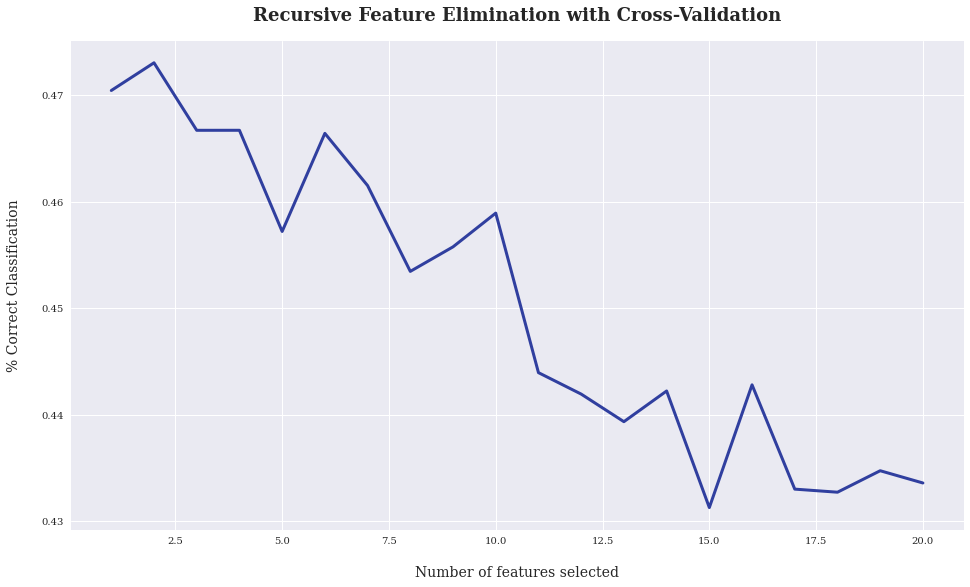

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

## Feature Selection

In [ ]:
#All Features:
features = ['Open', 'SMA1', 'SMA2', 'SMA3', 'OSMA1', 'OSMA2', 'OSMA3', 'SMA1_ratio', 'SMA2_ratio', 'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2','Op_OSMA3', 'Open_Ratio', 'OC_Ratio', 'lag_1', 'lag_2', 'lag_7','lag_8', 'lag_15']

#features= ['Open','Open_Ratio','O/C_Ratio','SMA1_ratio', 'SMA2_ratio', 'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2', 'Op_OSMA3', 'lag_1', 'lag_2', 'lag_7', 'lag_8', 'lag_15']
#features= ['O/C_Ratio','SMA1_ratio', 'SMA3_ratio', 'SMA2_ratio','lag_7','lag_8', 'lag_15', 'lag_2']
#features =['Open', 'O/C_Ratio', 'SMA1_ratio', 'SMA2_ratio', 'Op_OSMA2','Op_OSMA2','lag_2','lag_7', 'lag_8', 'lag_15']
#features= ['Open_Ratio','O/C_Ratio','SMA1_ratio', 'SMA2_ratio', 'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2', 'Op_OSMA3','lag_1', 'lag_2', 'lag_7', 'lag_8', 'lag_15']
#features = ['Open','SMA1_ratio', 'SMA2_ratio', 'SMA3_ratio', 'Op_OSMA1', 'Op_OSMA2','Op_OSMA3', 'Open_Ratio', 'O/C_Ratio', 'lag_1', 'lag_2', 'lag_7','lag_8', 'lag_15']
#feature_Vol =['SMA1', 'SMA2', 'OSMA1', 'OSMA2','lag_1', 'lag_2', 'Vol_lag']



targets = [symbol, 'daily_ration', 'return', 'direction']

OC_Ratio       1
SMA1_ratio     1
PK_ratio       1
SMA3           1
lag_2          1
PA_ratio       1
lag_7          1
Tenkan         1
SpanB

In [ ]:
# Features for XGBoost
features = ['Open','OC_Ratio','SMA1_ratio','PK_ratio','SMA3','lag_2','PA_ratio','lag_7','Tenkan','SpanB']

In [ ]:
# RandomForest Features based on RFE
#features =['lag_15','SMA1_ratio', 'SMA2_ratio', 'Op_OSMA1', 'Op_OSMA3','OC_Ratio']
#features = ['lag_15','lag_7', 'Open_Ratio', 'SMA1', 'SMA3','OC_Ratio', 'SMA1_ratio']
features = ['Open', 'lag_7']

lag_15         1
lag_7          1
PB_ratio       1
OC_Ratio       1
Open_Ratio     1
SMA3           1
SMA1_ratio     1

In [ ]:
#Features based on Markov Blanket
features =['lag_15', 'Op_OSMA1','OC_Ratio']

In [ ]:
# RandomForest Features based on RFE + Markove
features =['lag_15','SMA1_ratio', 'SMA2_ratio', 'Op_OSMA1', 'Op_OSMA3','O/C_Ratio', 'Op_OSMA1']

In [ ]:
#Logistics RFE Features
#features =['Open','SMA1','OMSA2','lag_1', 'lag_2', 'lag_8']
#features =['Tenkan', 'Kinjun', 'SMA1', 'OC_Ratio', 'Open_Ratio', 'OSMA2', 'lag_1']
features =['SMA3_ratio', 'lag_2']

SMA3_ratio     1
lag_2          1

In [ ]:
# Logistics & Markov
#features =['Open','SMA2', 'OSMA2', 'lag_1', 'lag_15', 'Op_OSMA1', 'OC_Ratio']
#features =['Open','SMA1','OSMA2','lag_1', 'lag_2', 'lag_8','lag_15', 'Op_OSMA1','O/C_Ratio']
#features =['Tenkan', 'Kinjun', 'SMA1', 'OC_Ratio', 'Open_Ratio', 'OSMA2', 'lag_1', 'lag_15', 'Op_OSMA1']
features = ['lag_15', 'Op_OSMA1','OC_Ratio', 'SMA3_ratio', 'lag_2']

In [ ]:
#GradientBoostClassifier based on RFE
#features =['Open','OC_Ratio', 'Op_OSMA3', 'SMA1_ratio','lag_8']
#features = ['Tenkan', 'Kinjun', 'SMA1', 'OC_Ratio', 'Open_Ratio', 'OSMA2', 'lag_1']
#features= ['OC_Ratio', 'SMA3_ratio', 'lag_2', 'Op_OSMA1', 'SMA2_ratio', 'OSMA3']
features = ['SMA3_ratio', 'lag_2','PA_ratio','PK_ratio', 'OC_Ratio','Op_OSMA1', 'lag_8', 'SMA2_ratio','SMA1_ratio', 
           'OSMA3']

In [ ]:
#XGbosst based on RFE
features =['Open','OC_Ratio', 'SMA1_ratio', 'PK_ratio', 'SMA3', 'lag_2', 'PA_ratio', 'lag_7']

Open           1
OC_Ratio       1
SMA1_ratio     1
PK_ratio       1
SMA3           1
lag_2          1
PA_ratio       1
lag_7          1

Tenkan        1
Kinjun        1
SMA1          1
OC_Ratio      1
Open_Ratio    1
OSMA2         1
lag_1         1

In [ ]:
#Combined set of Features
features =['Open', 'SMA1', 'OSMA2', 'SMA1_ratio', 'SMA2_ratio', 'Op_OSMA1', 'Op_OSMA3','O/C_Ratio', 'lag_15', 'lag_8']

In [ ]:
# Standardize Features
var_c = ['SMA1', 'SMA2', 'OSMA1', 'OSMA2', 'lag_1', 'lag_2', 'lag_15']
standardize = lambda x: (x-x.mean()) / x.std()
for f in var_c:
  data[f] = data[f].pipe(standardize)

In [ ]:
data.dropna(inplace=True)
data['direction'].value_counts()

###Split Data

In [ ]:
# create train test partition
train = data['2001-01-05':'2014-12-31']
test  = data['2015-01-01':'2019-01-01']
validation = data['2019-01-01':]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)
print('Valid Dataset:', validation.shape)

Train Dataset: (3469, 35)
Test Dataset: (1006, 35)
Valid Dataset: (388, 35)


In [ ]:
yTrain = train[target]
xTrain = train[features]
yTest = test[target]
xTest = test[features]
yValid = validation[target]
xValid = validation[features]
#xTrain, xTest, yTrain,yTest = train_test_split(X, y, test_size=0.3, random_state=21)
xTrain.head()

,lag_15,Op_OSMA1,OC_Ratio
Date,,,
2001-03-19,1.820000,0.988444,1.006521
2001-03-20,-0.360001,1.008296,1.004687
2001-03-21,-2.800003,0.984763,0.999825
2001-03-22,0.549995,0.976635,0.997862
2001-03-23,1.110001,1.000884,1.019168


In [ ]:
#xTrain = scaler.transform(xT)
#xTest = scaler.transform(xTs)

In [ ]:
from google.colab import files
#train[features].to_csv('StockTrain.csv', header=True)
#files.download('StockTrain.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Train Multiple Models

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report

In [ ]:
classifiers = [GradientBoostingClassifier(random_state=0, n_estimators=1000),
               LogisticRegression(random_state=1234, max_iter=1000),
               RandomForestClassifier(random_state=1234, n_estimators=1000),
               GaussianNB()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
  model = cls.fit(xTrain,yTrain)
  yproba = model.predict_proba(xTest)[::,1]
  
  fpr, tpr, _ = roc_curve(yTest,  yproba)
  auc = roc_auc_score(yTest, yproba)
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

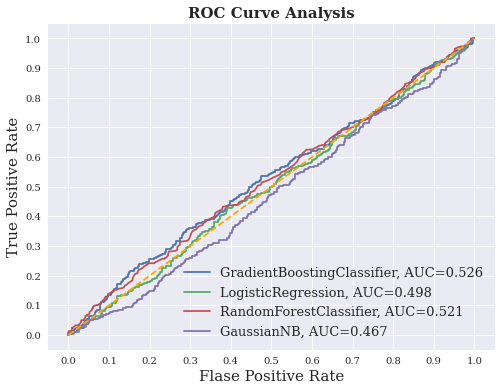

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:
print("Results for New Logit+Markov: ")
result_table

Results for New Logit+Markov: 


,fpr,tpr,auc
classifiers,,,
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.002079002079002079, 0.002079...","[0.0, 0.0019047619047619048, 0.005714285714285...",0.482790
LogisticRegression,"[0.0, 0.0, 0.0, 0.002079002079002079, 0.002079...","[0.0, 0.0019047619047619048, 0.007619047619047...",0.506124
RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.004158004158004158, 0.0...","[0.0, 0.0019047619047619048, 0.003809523809523...",0.490334


In [ ]:
print("Results for Cobmined set of features: ")
result_table

Results for Cobmined set of features: 


,fpr,tpr,auc
classifiers,,,
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.002079002079002079, 0.002079...","[0.0, 0.0019047619047619048, 0.005714285714285...",0.533226
LogisticRegression,"[0.0, 0.002079002079002079, 0.0020790020790020...","[0.0, 0.0, 0.0019047619047619048, 0.0019047619...",0.514979
RandomForestClassifier,"[0.0, 0.0, 0.002079002079002079, 0.00207900207...","[0.0, 0.0038095238095238095, 0.003809523809523...",0.521742


In [ ]:
print("Models based on Markov Blanket Vars: ")
result_table

Models based on Markov Blanket Vars: 


,fpr,tpr,auc
classifiers,,,
GradientBoostingClassifier,"[0.0, 0.0, 0.002079002079002079, 0.00207900207...","[0.0, 0.0019047619047619048, 0.001904761904761...",0.516915
LogisticRegression,"[0.0, 0.0, 0.006237006237006237, 0.00623700623...","[0.0, 0.0019047619047619048, 0.001904761904761...",0.552076
RandomForestClassifier,"[0.0, 0.002079002079002079, 0.0041580041580041...","[0.0, 0.0, 0.0, 0.0019047619047619048, 0.00571...",0.507574


##Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score

In [ ]:
# group / ensemble of models 
estimator = [] 
estimator.append(('LR', LogisticRegression(solver ='lbfgs',  max_iter = 200))) 
estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier())) 

estimators = [('gb', gbmodel), ('rf', rfmodel), ('lr', logmodel), ('sv', svmodel)]
# Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimators, voting ='hard') 
vot_hard.fit(xTrain, yTrain) 
y_pred = vot_hard.predict(xTest) 
  
# using accuracy_score metric to predict accuracy 
score = accuracy_score(yTest, y_pred) 
print("Hard Voting Score % d" % score) 
  

Hard Voting Score  0


In [ ]:
print(classification_report(yTest, y_pred))

              precision    recall  f1-score   support

          -1       0.48      0.47      0.47       481
           1       0.53      0.54      0.53       525

    accuracy                           0.50      1006
   macro avg       0.50      0.50      0.50      1006
weighted avg       0.50      0.50      0.50      1006



In [ ]:
gbmodel = GradientBoostingClassifier(random_state=0)
rfmodel = RandomForestClassifier(random_state=1234)
logmodel = LogisticRegression(random_state=1234)
svmodel = SVC(gamma ='auto', probability = True)

gbmodel.fit(xTrain, yTrain)
rfmodel.fit(xTrain, yTrain)
logmodel.fit(xTrain, yTrain)
#svmodel.fit(xTrain, yTrain)

gpred=gbmodel.predict_proba(xTest)[::,1]
rpred = rfmodel.predict_proba(xTest)[::,1]
lpred = logmodel.predict_proba(xTest)[::,1]
#svpred = svModel.predict(xTest)

'''  
fpr, tpr, _ = roc_curve(yTest,  yproba)
  auc = roc_auc_score(yTest, yproba)
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

'''
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
finalpred=(gpred*0.25+rpred*0.25+lpred*0.25+svpred*0.25)

# Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(xTrain, yTrain) 
ypred = vot_hard.predict(xTest) 




KeyError: ignored

In [ ]:
finalpred.astype('int')

In [ ]:
print('Performance of ')
print(classification_report(yTest, finalpred.astype('int')))

## Logistic Regression

In [ ]:
logmodel = LogisticRegression(random_state=0, max_iter=1000)
logmodel = logmodel.fit(xTrain,yTrain)
yproba = logmodel.predict_proba(xTest)[::,1]

In [ ]:
logmodel.coef_

array([[ 0.01285903,  0.01125236, -0.06415214,  0.01052175,  0.01175688,
         0.00055664]])

In [ ]:
# LogModel's prediction for Direction
pred = logmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.42      0.02      0.04       481
           1       0.52      0.97      0.68       525

    accuracy                           0.52      1006
   macro avg       0.47      0.50      0.36      1006
weighted avg       0.47      0.52      0.37      1006



In [ ]:
# LogModel's prediction for UP & Down Directions
pred = logmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.57      0.09      0.16       481
           1       0.53      0.94      0.68       525

    accuracy                           0.53      1006
   macro avg       0.55      0.51      0.42      1006
weighted avg       0.55      0.53      0.43      1006



## Train Xgboost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
Xgmodel = XGBClassifier(n_estimators=1000) 
Xgmodel.fit(xTrain, yTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pred = Xgmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.50      0.66      0.57       481
           1       0.56      0.40      0.47       525

    accuracy                           0.52      1006
   macro avg       0.53      0.53      0.52      1006
weighted avg       0.53      0.52      0.52      1006



In [ ]:
print(features)
pred = Xgmodel.predict(xTest)
print(classification_report(yTest, pred))

['Open', 'OC_Ratio', 'SMA1_ratio', 'PK_ratio', 'SMA3', 'lag_2', 'PA_ratio', 'lag_7']
              precision    recall  f1-score   support

          -1       0.50      0.66      0.57       481
           1       0.56      0.40      0.47       525

    accuracy                           0.52      1006
   macro avg       0.53      0.53      0.52      1006
weighted avg       0.53      0.52      0.52      1006



(0.0, 1.0)

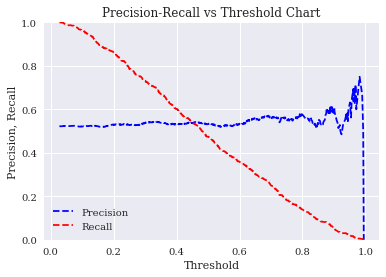

In [ ]:
from sklearn.metrics import f1_score
model = Xgmodel
X = xTest
Y = yTest
predy=model.predict(X)

proby=model.predict_proba(X) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Y, proby[:, 
1]) 
   #retrieve probability of being 1(in second column of probsy)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [ ]:
f1_scores = 2*recall*precision/(recall+precision)
best_tresh = thresholds[np.argmax(f1_scores)]
print('Best threshold: ', best_tresh)
#print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.9947242
Best F1-Score:  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


##Gradient Boost Model

In [ ]:
gbmodel = GradientBoostingClassifier(random_state=0, n_estimators=1000, max_depth=5)
gbmodel.fit(xTrain,yTrain)


In [ ]:
# GBM prediction for Direction with 1,000 Trees
pred = gbmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.50      0.41      0.45       481
           1       0.54      0.63      0.58       525

    accuracy                           0.52      1006
   macro avg       0.52      0.52      0.52      1006
weighted avg       0.52      0.52      0.52      1006



In [ ]:
# GBM prediction for Direction with 10,000 Trees
pred = gbmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.49      0.45      0.47       481
           1       0.53      0.57      0.55       525

    accuracy                           0.52      1006
   macro avg       0.51      0.51      0.51      1006
weighted avg       0.51      0.52      0.51      1006



(0.0, 1.0)

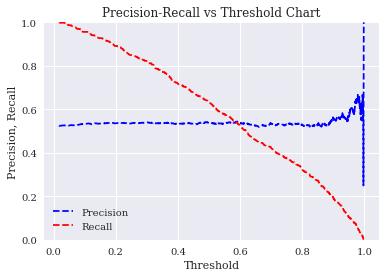

In [ ]:
from sklearn.metrics import f1_score
model = gbmodel
X = xTest
Y = yTest
predy=model.predict(X)

proby=model.predict_proba(X) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Y, proby[:, 
1]) 
   #retrieve probability of being 1(in second column of probsy)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [ ]:
f1_scores = 2*recall*precision/(recall+precision)
best_tresh = thresholds[np.argmax(f1_scores)]
print('Best threshold: ', best_tresh)
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.03358621544642713
Best F1-Score:  0.6894736842105263


In [ ]:
tresh = 0.03358
y_pred = (model.predict_proba(X)[:,1] >= tresh).astype(bool)
prmetrics = classification_report(Y, y_pred)
print(prmetrics)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       481
           0       0.00      0.00      0.00         0
           1       0.53      1.00      0.69       525

    accuracy                           0.52      1006
   macro avg       0.18      0.33      0.23      1006
weighted avg       0.27      0.52      0.36      1006



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df = train
gmodel = XGBClassifier()
gmodel.fit(xTrain,yTrain)
print(gmodel)

## Train RF Model

In [ ]:
df = train
RFmodel = RandomForestClassifier(random_state=1, n_estimators = 10000, oob_score=True) #Enables using out-of-bag sample set for validation
RFmodel.fit(xTrain, yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
print(features, 'for RF model')
# 10,000 Tree RF Model's prediction for Direction
pred = RFmodel.predict(xTest)
print(classification_report(yTest, pred))

['lag_15', 'Op_OSMA1', 'OC_Ratio'] for RF model
              precision    recall  f1-score   support

          -1       0.49      0.44      0.46       481
           1       0.53      0.57      0.55       525

    accuracy                           0.51      1006
   macro avg       0.51      0.51      0.51      1006
weighted avg       0.51      0.51      0.51      1006



In [ ]:
print(features, 'for RF model')
# 10,000 Tree RF Model's prediction for Direction
pred = RFmodel.predict(xTest)
print(classification_report(yTest, pred))

['Open', 'lag_7'] for RF model
              precision    recall  f1-score   support

          -1       0.49      0.42      0.45       481
           1       0.53      0.60      0.56       525

    accuracy                           0.51      1006
   macro avg       0.51      0.51      0.50      1006
weighted avg       0.51      0.51      0.51      1006



In [ ]:
# 10,000 Tree RF Model's prediction for Direction
pred = RFmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.48      1.00      0.65       481
           1       1.00      0.01      0.01       525

    accuracy                           0.48      1006
   macro avg       0.74      0.50      0.33      1006
weighted avg       0.75      0.48      0.32      1006



In [ ]:
# RF Model's prediction for UpDirection
pred = RFmodel.predict(xTest)
print(classification_report(yTest, pred))

              precision    recall  f1-score   support

          -1       0.49      0.53      0.51       481
           1       0.54      0.50      0.52       525

    accuracy                           0.52      1006
   macro avg       0.52      0.52      0.52      1006
weighted avg       0.52      0.52      0.52      1006



In [ ]:
model = RFmodel
test['predict'] = model.predict(xTest)
print("Training score:", model.score(xTrain, yTrain))
print("Out-of-bag score:", model.oob_score_)
print("Testing score:", model.score(xTest, yTest))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Training score: 0.9991351974632459
Out-of-bag score: 0.5110982992216777
Testing score: 0.510934393638171


In [ ]:
model = RFmodel
df = test
df['predict'] = model.predict(xTest)
print("Training score:", model.score(xTrain, yTrain))
print("Out-of-bag score:", model.oob_score_)
print("Testing score:", model.score(xTest, yTest))

NameError: ignored

(0.0, 1.0)

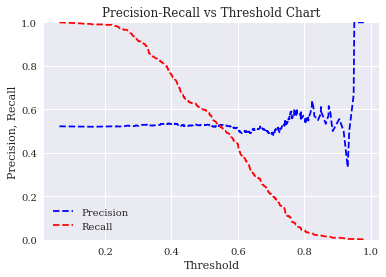

In [ ]:
from sklearn.metrics import f1_score
model = RFmodel
X = xTest
Y = yTest
predy=model.predict(X)

proby=model.predict_proba(X) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Y, proby[:, 
1]) 
   #retrieve probability of being 1(in second column of probsy)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### Assess Feature Importance

In [ ]:
feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
feature_imp

In [ ]:
#feature_imp=[]
feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
feature_imp

In [ ]:
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

##Model Validation

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:

target_predict = model.predict(xTest)
confusion = confusion_matrix(yTest, target_predict)

print("Accuracy:",metrics.accuracy_score(yTest, pred))
print(confusion)

Accuracy: 0.5198807157057654
[[218 263]
 [217 308]]


In [ ]:
model = logmodel
df=test
df['predict'] = model.predict(xTest)
df['strat']= df['predict']* df['return']
(df[target]==df['predict']).value_counts()/df.shape[0]

ValueError: ignored

In [ ]:
model = gbmodel
df=test
df['predict'] = model.predict(df[features])
df['strat']= df['predict']* df['return']
(df[target]==df['predict']).value_counts()/df.shape[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


True     0.524851
False    0.475149
dtype: float64

In [ ]:
model = RFmodel
df=test
df['predict'] = RFmodel.predict(df[features])
df['strat']= df['predict']* df['return']
(df[target]==df['predict']).value_counts()/df.shape[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


True     0.510934
False    0.489066
dtype: float64

Backtesting

In [ ]:
model = logmodel
for i in [test, validation]:
  df = i
  df['predict'] = model.predict(df[features])
  df['strat']= df['predict']* df['return']
  print('Results for ')
  print('Buy & Hold Return: ', df['return'].sum())
  print('Strategy Return: ', df['strat'].sum())

Results for 
Buy & Hold Return:  -7.6002655029296875
Strategy Return:  18.139846801757812
Results for 
Buy & Hold Return:  48.92970275878906
Strategy Return:  -13.890243530273438


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
for i in [test, validation]:
  df = i
  df['predict'] = gbmodel.predict(df[features])
  df['strat']= df['predict']* df['return']
  print('Results for ')
  print('Buy & Hold Return: ', df['return'].sum())
  print('Strategy Return: ', df['strat'].sum())


Results for 
Buy & Hold Return:  -7.6002655029296875
Strategy Return:  -93.31925964355469
Results for 
Buy & Hold Return:  48.92970275878906
Strategy Return:  4.9294891357421875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
for model in [logmodel, gbmodel] :#, RFmodel]:
  modelname = str(model)
  df = validation
  df['predict'] = model.predict(df[features])
  df['strat']= df['predict']* df['return']
  print('Results for ', modelname, 'strategy is: ', df['strat'].sum()) #.apply(np.exp)
print('Baseline Buy & Hold return: ', df['return'].sum())

Results for  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) strategy is:  -13.890243530273438
Results for  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


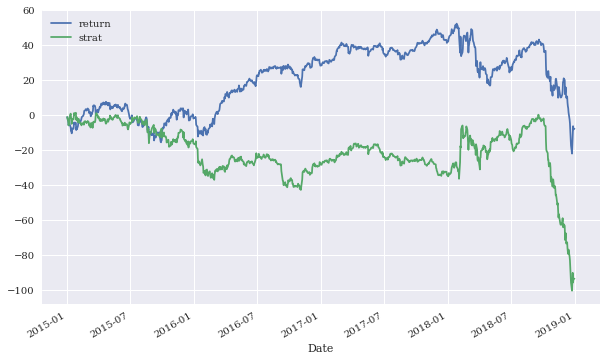

In [ ]:
model = gbmodel
df = test
df['predict'] = model.predict(df[features])
df['strat']= df['predict']* df['return']
market = df['return']
strategy = df['strat']
se1= [market, strategy]
figdata=df[['return', 'strat']].cumsum().plot(figsize=(10,6))


In [ ]:
df1=df.tail(100)
(df1['direction']==df1['predict']).value_counts()/df1.shape[0]

True     0.55
False    0.45
dtype: float64

In [ ]:
df.tail(10)

,SPY,Open,close_ratio,diff,daily_change,return,direction,SMA1,SMA2,SMA3,OSMA1,OSMA2,OSMA3,SMA1_ratio,SMA2_ratio,SMA3_ratio,Op_OSMA1,Op_OSMA2,Op_OSMA3,Open_Ratio,O/C_Ratio,lag_1,lag_2,lag_7,lag_8,lag_15,predict,strat
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,312.230011,314.239990,0.005507,1.710022,0.993604,-2.009979,-1,307.779989,307.187492,308.338120,309.266663,307.771248,308.850624,1.004830,1.001900,1.001662,1.016081,1.021018,1.017450,1.015085,1.011980,0.949982,4.369995,-1.440002,2.630005,-10.850006,1,-2.009979
2020-07-06,317.049988,316.369995,0.015437,4.819977,1.002149,0.679993,1,310.369995,307.388744,307.914995,313.393331,308.131248,309.157499,1.009741,1.002416,1.004035,1.009498,1.026738,1.023330,1.006778,1.013259,-2.009979,0.949982,-5.750000,-1.440002,-4.029999,1,0.679993
2020-07-07,313.779999,315.380005,-0.010314,-3.269989,0.994927,-1.600006,-1,313.266663,308.013744,308.942495,315.329997,308.823750,309.603750,1.006587,1.002630,1.002140,1.000159,1.021230,1.018657,0.996871,0.994733,0.679993,-2.009979,3.880005,-5.750000,9.029999,1,-1.600006
2020-07-08,316.179993,314.609985,0.007649,2.399994,1.004990,1.570007,1,314.353333,309.224995,309.540621,315.453328,310.216248,310.640625,1.003499,1.003206,1.003554,0.997327,1.014163,1.012778,0.997558,1.002645,-1.600006,0.679993,-6.110016,3.880005,-2.520020,1,1.570007
2020-07-09,314.380005,316.839996,-0.005693,-1.799988,0.992236,-2.459991,-1,315.669993,310.328743,310.111246,315.609996,311.551247,310.725624,0.999810,1.003939,1.001981,1.003897,1.016976,1.019678,1.007088,1.002087,1.570007,-1.600006,3.049988,-6.110016,-2.410004,1,-2.459991
2020-07-10,317.589996,314.309998,0.010211,3.209991,1.010436,3.279999,1,314.779999,312.119995,310.199997,315.253326,313.163746,310.740623,1.001504,1.003344,1.001743,0.997008,1.003660,1.011487,0.992015,0.999777,-2.459991,1.570007,4.369995,3.049988,1.769989,1,3.279999
2020-07-13,314.839996,320.130005,-0.008659,-2.750000,0.983475,-5.290009,-1,316.049998,313.761246,310.570621,317.093333,315.181248,311.373123,1.003301,1.004526,1.002584,1.009577,1.015701,1.028123,1.018517,1.007998,3.279999,-2.459991,0.949982,4.369995,-5.529999,1,-5.290009
2020-07-14,318.920013,313.299988,0.012959,4.080017,1.017938,5.620026,1,315.603333,314.571247,310.761871,315.913330,315.647495,311.318747,1.000982,1.003421,1.001792,0.991728,0.992563,1.006364,0.978665,0.995109,-5.290009,3.279999,-2.009979,0.949982,2.630005,1,5.620026
2020-07-15,321.850006,322.410004,0.009187,2.929993,0.998263,-0.559998,-1,317.116669,315.621250,311.404371,318.613332,316.668747,312.219997,1.004720,1.003319,1.002619,1.011916,1.018130,1.032637,1.029078,1.010943,5.620026,-5.290009,0.679993,-2.009979,-1.440002,1,-0.559998


In [ ]:
df[[symbol, 'Open','return', 'direction', 'predict']].tail(10)

,SPY,Open,return,direction,predict
Date,,,,,
2020-07-02,312.230011,314.239990,-2.009979,-1,1
2020-07-06,317.049988,316.369995,0.679993,1,1
2020-07-07,313.779999,315.380005,-1.600006,-1,1
2020-07-08,316.179993,314.609985,1.570007,1,1
2020-07-09,314.380005,316.839996,-2.459991,-1,1
2020-07-10,317.589996,314.309998,3.279999,1,1
2020-07-13,314.839996,320.130005,-5.290009,-1,1
2020-07-14,318.920013,313.299988,5.620026,1,1
2020-07-15,321.850006,322.410004,-0.559998,-1,1
